# Guassian mixture intra-song clustering for identification of "main" beats

If $X_1, \ldots, X_n$ are i.i.d. normal, then the $1 - \alpha$ confidence region is a circle of radius $r$ where
$$P(X_1^2 + \cdots + X_n^2 \leq r^2) =1 - \alpha$$
i.e. given by the square root of the $1-\alpha$ quantile for the chi-squared distribution with $n$ d.f.

A multivariate normal distribution $Y$ with covariance $\Sigma = U S U^t$ is transformed from a standard one $X$ by $Y = AX$ where $A = U S^{1/2}$.  The unit circle is transformed to an ellipse with axes given by the columns of $U$ and axis lengths by $S$.

We default to 95% confidence but I think this might be too strict.

In [2]:
from matplotlib.patches import Ellipse
import scipy, math
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt


# Get Matplotlib patches for various elliptical confidence regions
def get_ellipse_patch(center, cov, confidence=0.95):
    # Figure out number of stdevs for confidence
    scale = math.sqrt(scipy.stats.chi2.ppf(q=confidence, df=center.shape[0]))
    
    u, s, vh = np.linalg.svd(cov)
    # If det < 0, reflect either u_1 or u_2 to its negative, may as well do u_2
    # For arccos, need y-value of u_1 to be positive
    if u[0,1] < 0:
        u[:,0] = -u[:,0]
    th = np.arccos(np.dot(np.array([1, 0]), u[:,0])) * 180 / np.pi
    print(np.sqrt(np.linalg.det(cov)))
    return Ellipse((center[0], center[1]), np.sqrt(s[0]) * scale * 2, np.sqrt(s[1])* scale * 2, angle=th, alpha=0.5, color='red')



# Check if the confidence region contains a list of points
# center shape (n,), covariance shape (n,n), points shape (p, n) where p is number of points
# Returns shape (n, 1) boolean
def ellipse_contains_points(center, covariance, points, confidence=0.95):
    u, s, vh = np.linalg.svd(covariance)
    a = u @ np.diag(np.sqrt(s))
    return np.linalg.norm((points - center) @ np.linalg.inv(a).T, axis=1) ** 2 < scipy.stats.chi2.ppf(q=confidence, df=center.shape[0])
    

# Gets patches and containment data for a given fitted GaussianMixture object
# Returns an list of patches, a Numpy array of containment data
def get_patches(gm, confidence, pts):
    patches = []
    contains = []
    for i in range(gm.means_.shape[0]):
        e = get_ellipse_patch(gm.means_[i], gm.covariances_[i], confidence=confidence)
        patches.append(e)
        contains.append(ellipse_contains_points(gm.means_[i], gm.covariances_[i], pts, confidence))

    return patches, np.stack(contains, axis=0)


# Algorithm for determining the number of components according to our winnowing criteria: no overlaps, and each 95% confidence region should contain 10% of all data points
def winnow_gm_components(data, start=10, confidence_limit=0.95):
    for i in range(start, 0, -1):
        gm = GaussianMixture(n_components=i)
        gm.fit(data)
        # If i = 1, then we are done anyway, so break
        if i == 1:
            break

        contains = []
        for j in range(i):
            contains.append(ellipse_contains_points(gm.means_[j], gm.covariances_[j], data, confidence=confidence_limit))
        contains = np.stack(contains)

        # Check if there are any overlaps, if so, continue
        if (contains.sum(axis=0) <= 1).prod().item() != 1:
            continue
        # Check if any ellipses contain less than 10% of data points
        if (contains.sum(axis=1) >= data.shape[0]/10).prod().item() != 1:
            continue
        # Otherwise, we are done
        return gm, i
        
    return gm, i


## Test on some generated data sets

Generate a single 2d normal distribution

(1000, 2)


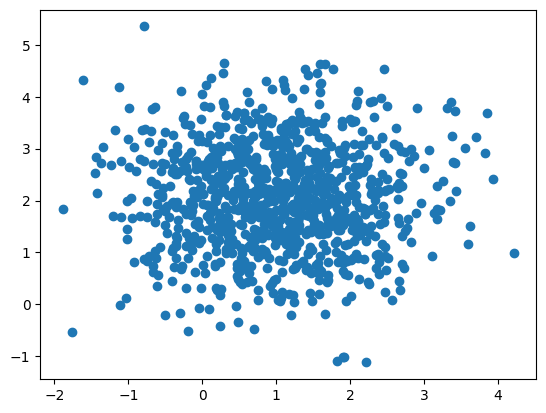

In [3]:
x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)

#x = np.concatenate([x1, x2])
#y = np.concatenate([y1, y2])

x = x1
y = y1

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


[[1.01431286 2.07443489]] [[[ 0.97823603 -0.0105943 ]
  [-0.0105943   1.01918724]]]
0.9984455131284524
Num covered: 0.897, valid covered: 0.897, overlapped: 0.0


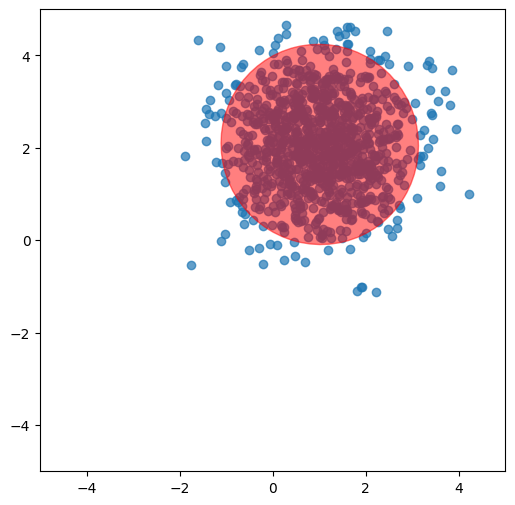

In [4]:
gm = GaussianMixture(n_components=1)


gm.fit(data)

print(gm.means_, gm.covariances_)

#bgm = BayesianGaussianMixture(n_components=2)
#bgm.fit(data)
#print(bgm.means_.shape)

patches, coverage = get_patches(gm, 0.9, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

p = patches[0]

print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")



plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

My conclusion from the below is that the patches "contains points" is buggy as shit.  (Note: comment out the set_axlim to fix at least one bug.)

In [5]:
p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data, confidence=0.90))).sum())

print(data.shape[0])
print(f"patch way: {p.contains_points(data).sum()}")
print(f"my way: {ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()}")


103
1000
patch way: 0
my way: 952


0.9984455131284524


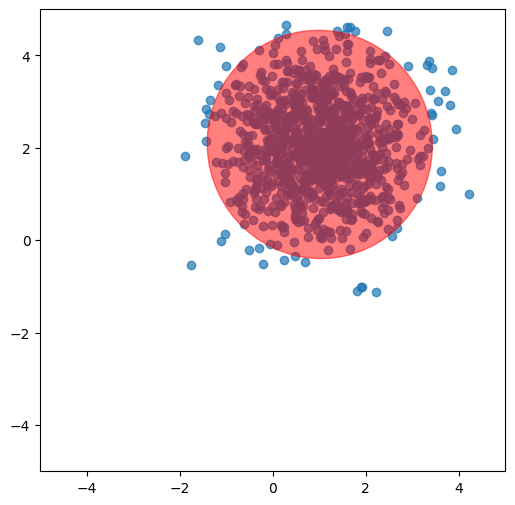

In [6]:
gm, i = winnow_gm_components(data)
i
patches, _ = get_patches(gm, 0.95, data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(500, 2)


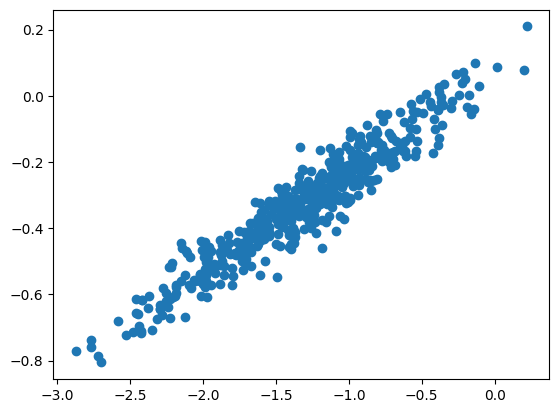

In [7]:
x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
u, s, vh = np.linalg.svd(a)
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


x = x2
y = y2


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)

[[-1.30264528 -0.32231302]] [[[0.29932302 0.08918084]
  [0.08918084 0.02924968]]]
0.028317498623068968
0.956


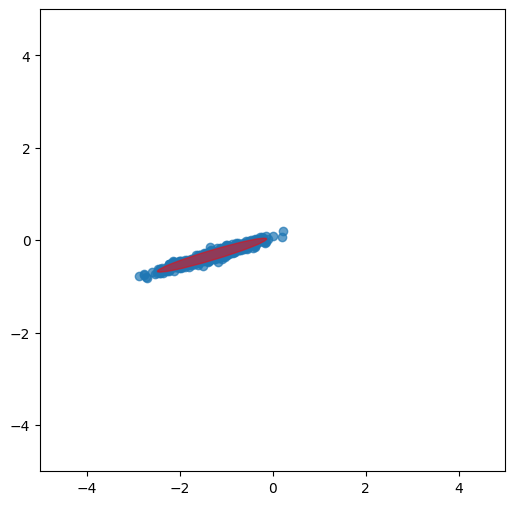

In [8]:
gm = GaussianMixture(n_components=1)
gm.fit(data)
print(gm.means_, gm.covariances_)

patches, coverage = get_patches(gm, 0.9, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


p = patches[0]

print(f"{ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()/data.shape[0]}")


(1500, 2)


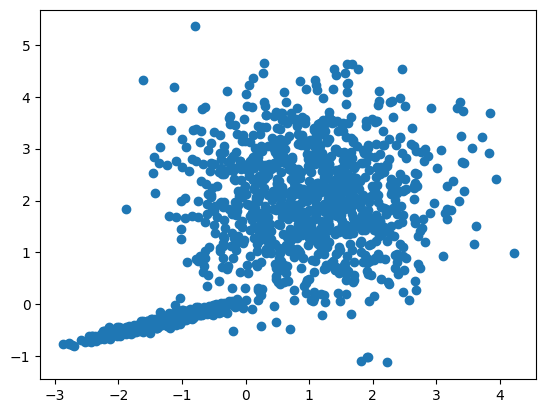

In [9]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



[[ 1.01772332  2.07889866]
 [-1.3011538  -0.32263189]] [[[ 0.97210777 -0.0194289 ]
  [-0.0194289   1.00987748]]

 [[ 0.30165013  0.08936995]
  [ 0.08936995  0.02921892]]]
0.9906221580059159
0.028755889059382166


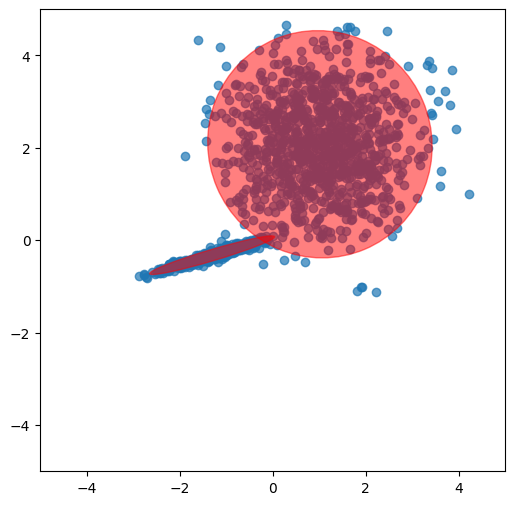

In [10]:
gm = GaussianMixture(n_components=2)
gm.fit(data)
print(gm.means_, gm.covariances_)


# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

In case we have overlap, the "center" gets shifted a bit.  Not sure if this is desirable or not.

1.4979475595404


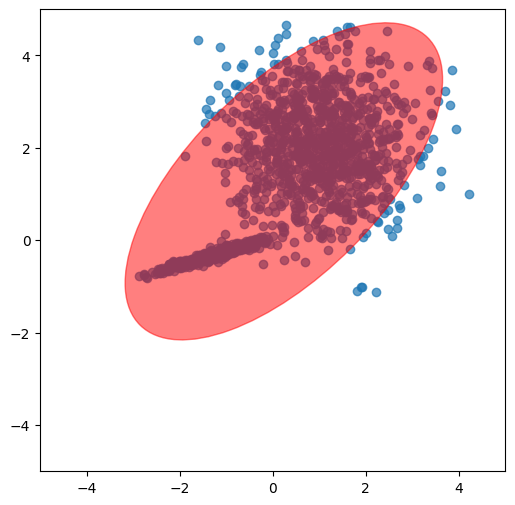

In [11]:
gm, i = winnow_gm_components(data)
i


patches, coverage = get_patches(gm, 0.95, data)
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(1500, 2)


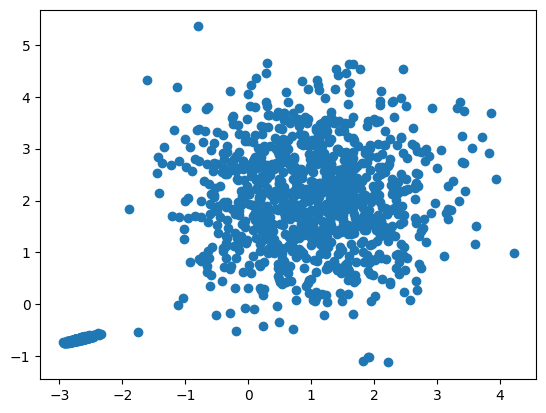

In [12]:
x3 = np.random.normal(loc=-2.0, scale=0.1, size=500)
y3 = np.random.normal(loc=-2.0, scale=0.1, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x3[:, None], y3[:, None]], axis=1) @ a
x3, y3 = v[:,0], v[:,1]


x = np.concatenate([x1, x3])
y = np.concatenate([y1, y3])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



0.9984496181367082
0.0010900228306431573


2

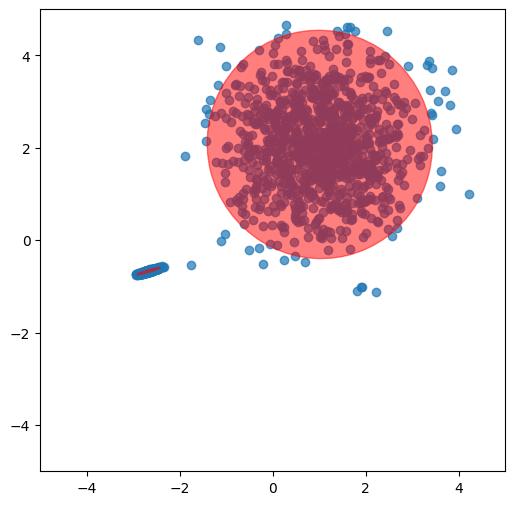

In [13]:
gm = GaussianMixture(n_components=2)
gm.fit(data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

patches, coverage = get_patches(gm, 0.95, data)

plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


gm, i = winnow_gm_components(data)
i

### Dumb bug

Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True
False


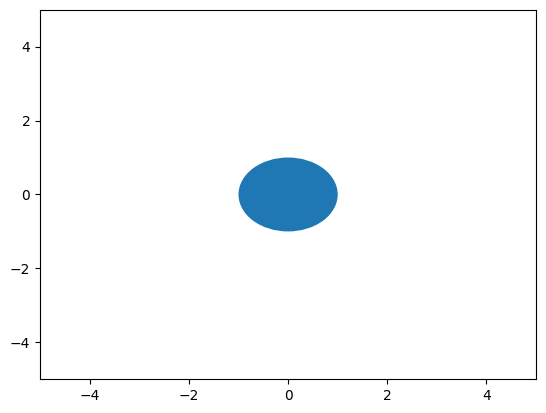

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

## Apply to beat data

### Get measure data

In [15]:
def beat_frames_to_toy(frames, len, target_len):
    x = np.zeros(len + ((target_len - len) % target_len))
    x[frames] = 1
    x = x.reshape((target_len, -1))
    x = x.max(axis=1)
    return x

def beat_frames_to_better_toy(frames, len, target_lens):
    outs = []
    for t in target_lens:
        outs.append(beat_frames_to_toy(frames, len, t))
    return np.concatenate(outs)


In [16]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
#from groove.embedding import beat_frames_to_toy
import numpy as np

file = "milaklaw"

raw, proc, sr = get_measures(file, smooth_power)
bf, nf = get_beat_frames(proc, sr, beat_peaks)

In [17]:
frames = np.array([4,4,7,9,11])

print(beat_frames_to_toy(frames, 12, 6))
print(beat_frames_to_better_toy(frames, 12, [6, 4, 3, 2]))

[0. 0. 1. 1. 1. 1.]
[0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.]


In [26]:
out = []
hashable = []
for i in range(len(bf)):
    a = beat_frames_to_better_toy(bf[i], nf[i], [24, 12, 8, 6, 4, 2])
    out.append(a)
    hashable.append(tuple(a.tolist()))

data = np.stack(out)
data.shape


array([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [19]:
import collections
counter = collections.Counter(hashable)

counter.values()
#counter.most_common(5)

dict_values([17, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 14, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 9, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
beat_frames_to_toy(bf[20], nf[20], 12)

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])

[13.34353134 11.88005225]
0.08467952143929335
0.5599385689454882


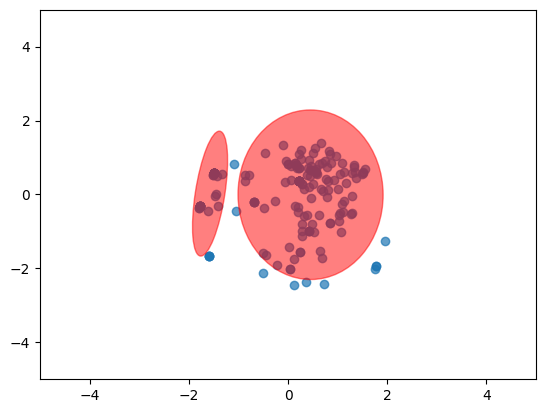

In [27]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
gm = GaussianMixture(n_components=2)


pca.fit(data)

print(pca.singular_values_)
red_data = pca.transform(data)

gm.fit(red_data)

patches, coverage = get_patches(gm, 0.95, red_data)

plt.figure()
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])



plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
for p in patches:
    ax.add_patch(p)


#gm.fit(data)
#gm.means_.round()

Some rules for choosing the number of components:
1) If there are overlaps between the 95%ile circles, we should reduce.
2) If any circles don't cover 10%, we reduce.

So, start with more, then reduce.

In [33]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

gm, i = winnow_gm_components(data)

print(i)
gm.means_

5


array([[0.72413793, 0.20689655, 0.        , 0.34482759, 0.03448276,
        0.        , 0.96551724, 0.06896552, 0.        , 0.31034483,
        0.37931034, 0.37931034, 0.79310345, 0.34482759, 0.        ,
        0.31034483, 0.96551724, 0.03448276, 1.        , 0.03448276,
        0.06896552, 0.72413793, 0.10344828, 0.        , 0.93103448,
        0.34482759, 0.03448276, 1.        , 0.31034483, 0.75862069,
        1.        , 0.31034483, 1.        , 1.        , 0.75862069,
        0.10344828, 0.93103448, 0.37931034, 1.        , 0.82758621,
        1.        , 1.        , 1.        , 0.79310345, 1.        ,
        1.        , 0.82758621, 1.        , 1.        , 0.82758621,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [0.91176471, 0.26470588, 0.02941176, 0.        , 0.        ,
        0.02941176, 0.76470588, 0.05882353, 0.05882353, 0.97058824,
        0.11764706, 0.02941176, 0.11764706, 0.        , 0.        ,
        0.76470588, 0.05882

(5, 56) (179, 56)
[ 79   0  23  85 125]


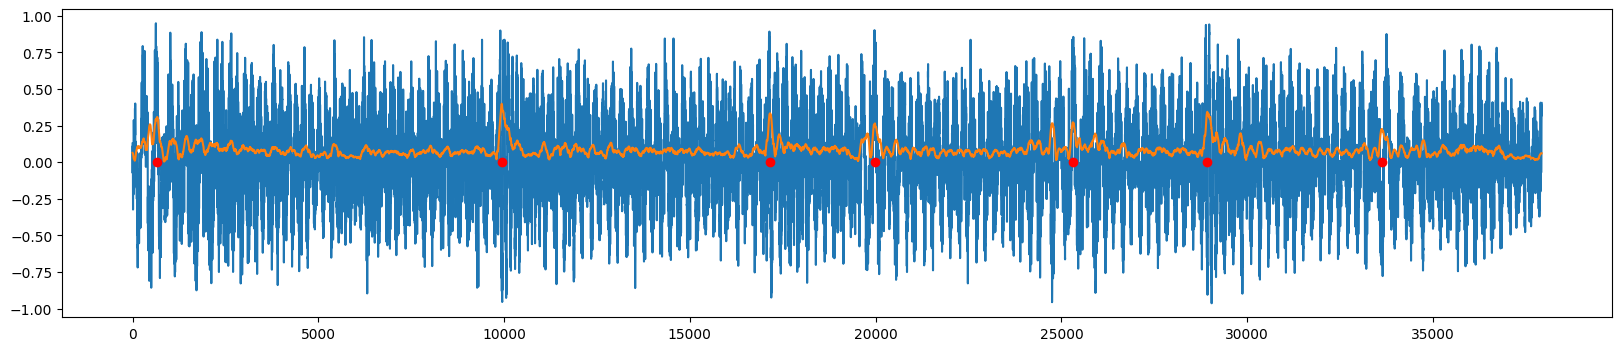

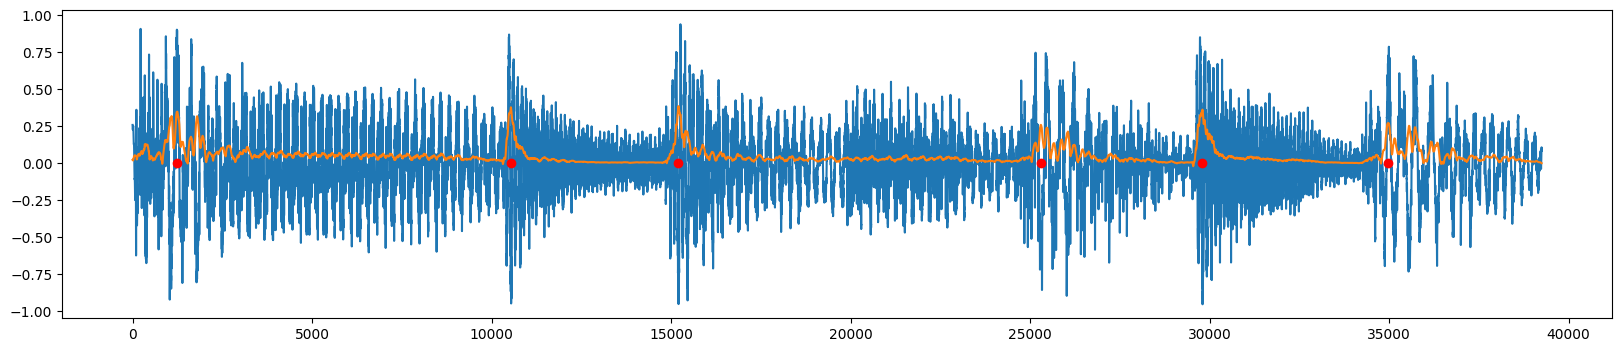

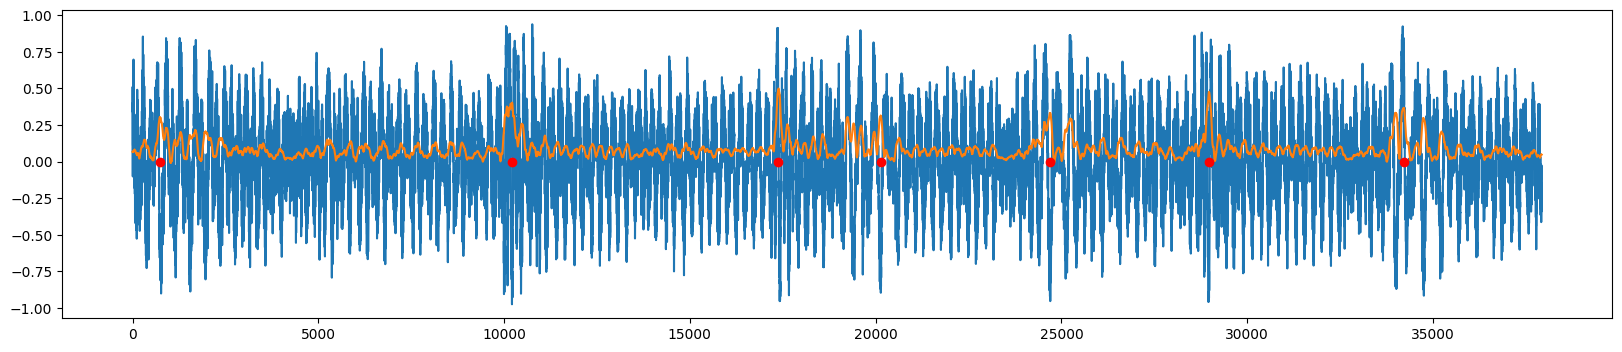

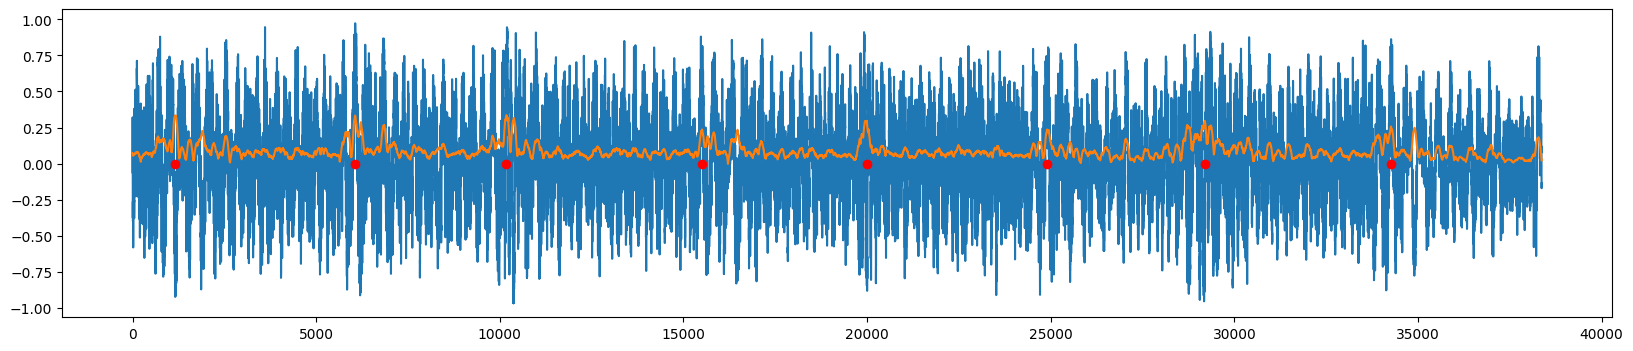

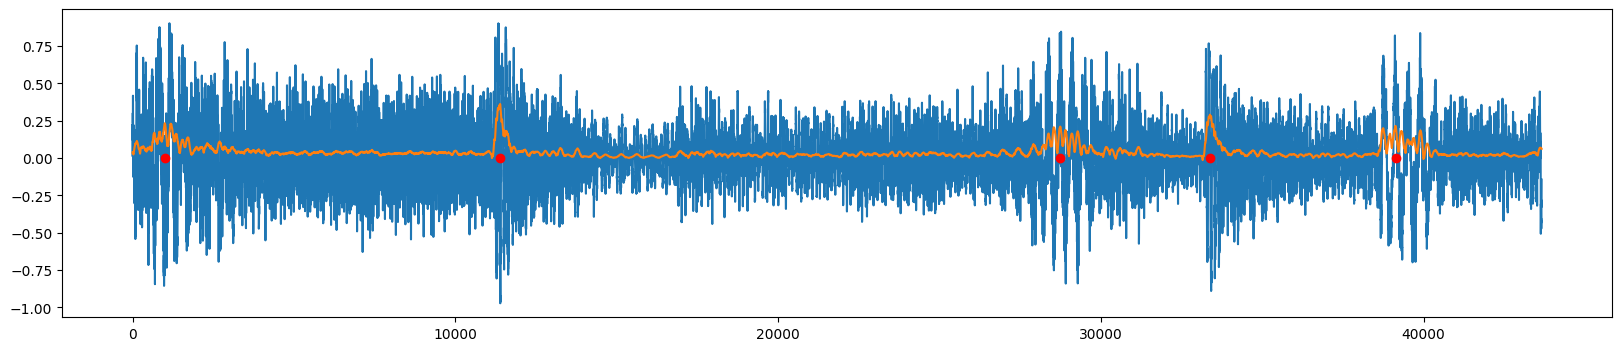

In [62]:
from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa

def find_closest_indices(means, data):
    outs = []
    for i in range(means.shape[0]):
        distances = np.linalg.norm(means[i] - data, axis=1)
        outs.append(distances.argmin(keepdims=True)[0])
    return np.stack(outs)

print(gm.means_.shape, data.shape)

inds = find_closest_indices(gm.means_, data)
data[inds]
print(inds)


raw_measures, proc_measures, sr = get_measures(file, smooth_power)
for i in inds:
    raw, proc = raw_measures[i], proc_measures[i]
    beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
    clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


    plt.figure(figsize=(20, 4))
    plt.plot(raw)
    plt.plot(proc)
    plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
    #display(Audio(data=raw, rate=sr))
    display(Audio(data=raw + clicks, rate=sr))


In [75]:
print(gm.means_[0] - gm.means_[2])
print(np.linalg.norm(gm.covariances_[0]))

[-1.09195402e-01  2.17113665e-02 -1.85185185e-02  2.70753512e-01
  1.59642401e-02 -1.85185185e-02  5.81098340e-02  1.34099617e-02
 -3.70370370e-02  3.25670498e-02 -4.91060026e-01  2.31162197e-01
 -1.88378033e-01  2.70753512e-01  0.00000000e+00 -5.97062580e-01
  8.72924649e-01 -5.81098340e-02  1.85185185e-01 -5.81098340e-02
  1.34099617e-02 -3.51213282e-02 -7.66283525e-03 -3.70370370e-02
 -1.34099617e-02  2.52234994e-01 -2.55427842e-03  9.25925926e-02
 -4.46998723e-03 -2.41379310e-01 -1.11022302e-16 -5.97062580e-01
  8.51851852e-01  1.48148148e-01 -1.91570881e-02 -2.61813538e-02
 -1.34099617e-02  2.68199234e-01  9.25925926e-02 -1.72413793e-01
 -1.11022302e-16  9.25925926e-02  1.29629630e-01 -4.02298851e-02
  3.70370370e-02  9.25925926e-02 -1.72413793e-01 -1.11022302e-16
  7.40740741e-02 -2.42656450e-02  3.70370370e-02 -1.11022302e-16
 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16 -1.11022302e-16]
1.670251632702874


My dumb toy embedding magnifies small differences.

In [107]:
print((data[inds[0]] - data[inds[2]])[:24])
print((data[inds[0]] - data[inds[2]])[24:24+12])
print((data[inds[0]] - data[inds[2]])[24+12:24+12+8])
print((data[inds[0]] - data[inds[2]])[24+12+8:24+12+8+4])
print((data[inds[0]] - data[inds[2]])[24+12+8+4:24+12+8+4+2])

u = data[inds[0]] - data[inds[2]]
print(np.linalg.norm(u))
print(u)

print((data[inds[0]] - data[inds[1]]))
print((data[inds[0]] - data[inds[1]])[:24])
print(np.linalg.norm(data[inds[0]] - data[inds[1]]))


get_beat_frames([proc_measures[79], proc_measures[23]], sr, beat_peaks)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0.]
2.0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  1.  0.  0. -1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1. -1.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  1.  0.  0. -1.  1.  0.
  0.  0.  0.  0.  0.  0.]
3.3166247903554


([array([  667,  9935, 17165, 19980, 25304, 28925, 33625]),
  array([  738, 10217, 17385, 20138, 24690, 28971, 34209])],
 [37926, 37926])

In [81]:
print((data[inds[0]] - data[inds[1]])[:24])
print((data[inds[0]] - data[inds[1]])[24:24+12])
print((data[inds[0]] - data[inds[1]])[24+12:24+12+8])
print((data[inds[0]] - data[inds[1]])[24+12+8:24+12+8+4])
print((data[inds[0]] - data[inds[1]])[24+12+8+4:24+12+8+4+2])


[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  1.  0.  0. -1.  1.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0. -1.  1.  1. -1.  1.  0.  0.  0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0.]
